In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

# Evaluating Models

You have successfully processed your data into a format that you can feed into Machine Learning models. You decide to train a few different models to see how they compare. Given the results that are coming out of your models, how do you summarise how well the model is performing.? How do you decide which model you should use?

In this section of the workshop we will apply different evaluations metrics to analyze how well our text classification algorithm performs. However these techniques can be used for any type of classification problem.

## Binary vs Multi-Class

There are two instances of classification problems. There is binary classification where you only have two groups that each input can be assigned to. An example would be determining if a tumor is cancerous or not. There is also multiclass classification. An example would be the 20 newsgroups problem. In this section we will focus on evaluation of binary classification models. However these techniques can usually be extended to apply to multi-class problems.

To turn the newsgroups data set into a binary classification problem we only consider two categories of news stories.

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

categories = ['talk.religion.misc', 'alt.atheism']
newsgroups_dataset = fetch_20newsgroups(categories=categories)

X_train, X_test, y_train, y_test = train_test_split(newsgroups_dataset.data, 
                                                    newsgroups_dataset.target, 
                                                    test_size=0.33,  
                                                    random_state=1,
                                                    shuffle=True)
print(f'{len(X_train)} training documents and {len(X_test)} test documents.')

574 training documents and 283 test documents.


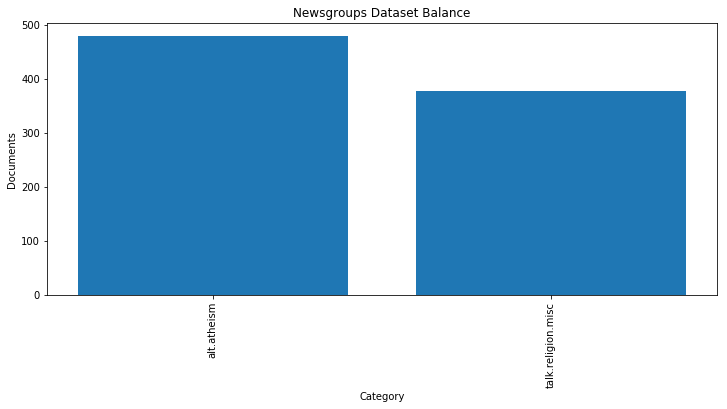

In [3]:
def plot_newsgroups_histogram(targets, class_names):
    bincount = np.bincount(targets)
    plt.figure(figsize=(12,5))
    plt.bar(class_names, bincount)
    plt.xticks(rotation=90)
    plt.xlabel("Category")
    plt.ylabel("Documents")
    plt.title("Newsgroups Dataset Balance")
    plt.show()
    plt.close()
    
plot_newsgroups_histogram(newsgroups_dataset.target, newsgroups_dataset.target_names)

Convert the text data to vectors using the Bag of Words method.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(lowercase='true', stop_words='english')
bow_vectorizer.fit(X_train)
bow_X_train = bow_vectorizer.transform(X_train) 
bow_X_test = bow_vectorizer.transform(X_test)

print(f'Vocabulary size: {len(bow_vectorizer.vocabulary_)}')

Vocabulary size: 14331


Train a logistic regression model

In [5]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)
classifier.fit(bow_X_train, y_train)
y_predict = classifier.predict(bow_X_test)

## Accuracy is the main metric used

Fraction of predictions which were correct. Of all the predictions that were made how many were correct.

$$ \textrm{Accuracy} = \frac{T_p + T_n}{T_p + T_n + F_p + F_n}$$

where $\qquad T_p$ = true positives, $\qquad\; T_n$ = true negatives

$\qquad\qquad F_p$ = False positives, $\qquad F_n$ = False negatives

In [6]:
true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0

for prediction, correct_value in zip(y_predict, y_test):
    if prediction == 1 and correct_value == 1:
        true_positive += 1
    if prediction == 1 and correct_value == 0:
        false_positive += 1
    if prediction == 0 and correct_value == 0:
        true_negative += 1
    if prediction == 0 and correct_value == 1:
        false_negative += 1
        
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f'Accuracy: {accuracy:.2f}')
print(f'Sklearn accuracy: {sklearn.metrics.accuracy_score(y_predict, y_test):.2f}')

Accuracy: 0.93
Sklearn accuracy: 0.93


For binary classification accuracy the worst possible value is 0.5

## Alternative metrics to accuracy

$$ \textrm{Precision},\:\:\:  P = \frac{T_p}{T_p+F_p} $$



$$ \textrm{Recall},\:\:\: R = \frac{T_p}{T_p + F_n} $$

Combine these two metrics to make F1 score

$$ \textrm{F1} = 2\frac{P \times R}{P+R} $$

Consider how $F1$ varies with respect to changes in $P$ or $R$.

In [7]:
precision = (true_positive) / (true_positive + false_positive)

print(f'Precision: {precision:.2f}')
print(f'Skearn precision: {sklearn.metrics.precision_score(y_test, y_predict):.2f}')

Precision: 0.90
Skearn precision: 0.90


In [8]:
recall = (true_positive) / (true_positive + false_negative)

print(f'Recall: {recall:.2f}')
print(f'Sklearn recall: {sklearn.metrics.recall_score(y_test, y_predict):.2f}')

Recall: 0.94
Sklearn recall: 0.94


In [9]:
f1_score = (2 * precision * recall) / (precision + recall)

print(f'F1 score: {f1_score:.2f}')
print(f'Sklearn F1 score: {sklearn.metrics.f1_score(y_test, y_predict):.2f}')

F1 score: 0.92
Sklearn F1 score: 0.92


## Using a confusion matrix to visualize where your model is struggling

![caption](confusion_matrix.png)

In [10]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_predict, y_test))
print(f'\nSum of confusion matrix should be {len(y_test)}')

[[150   7]
 [ 13 113]]

Sum of confusion matrix should be 283


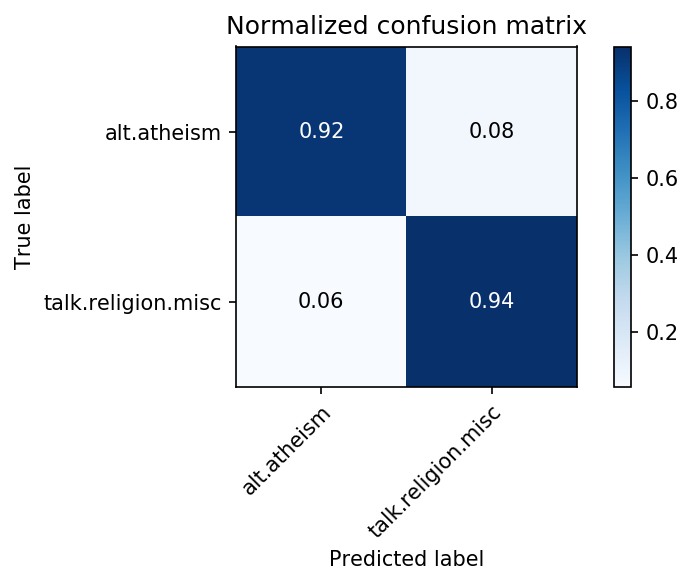

In [11]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)

    fig, ax = plt.subplots(dpi=150)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    plt.close()

plot_confusion_matrix(y_test, y_predict, 
                      classes=newsgroups_dataset.target_names,
                      title='Normalized confusion matrix')

# Imbalanced data set

368 training documents and 182 test documents.


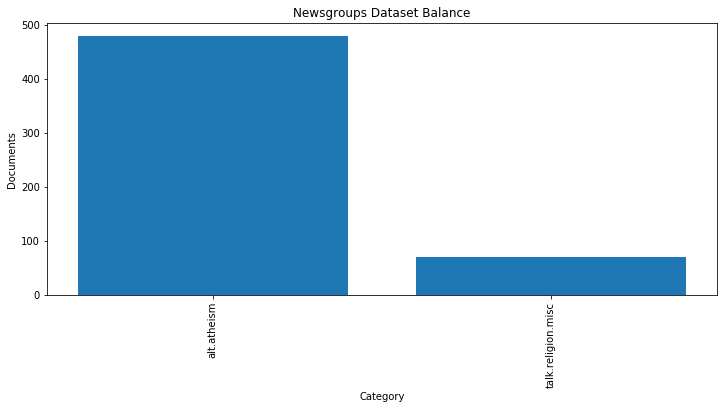

In [12]:
atheism_data = fetch_20newsgroups(categories=['alt.atheism']).data
religion_data = fetch_20newsgroups(categories=['talk.religion.misc']).data[:70]

imbalanced_data =  atheism_data + religion_data
imbalanced_target = np.array([0]*len(atheism_data) + [1]*len(religion_data))

X_train, X_test, y_train, y_test = train_test_split(imbalanced_data, 
                                                    imbalanced_target, 
                                                    test_size=0.33,
                                                    random_state=1,
                                                    shuffle=True)
print(f'{len(X_train)} training documents and {len(X_test)} test documents.')

plot_newsgroups_histogram(imbalanced_target, ['alt.atheism', 'talk.religion.misc'])

In [13]:
bow_vectorizer = CountVectorizer(lowercase='true', stop_words='english')
bow_vectorizer.fit(X_train)
bow_X_train = bow_vectorizer.transform(X_train) 
bow_X_test = bow_vectorizer.transform(X_test)

print(f'Vocabulary size: {len(bow_vectorizer.vocabulary_)}')

Vocabulary size: 11029


In [15]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)
classifier.fit(bow_X_train, y_train)
y_predict = classifier.predict(bow_X_test)

$$ $$
$$ \textrm{Accuracy} = \frac{T_p + T_n}{T_p + T_n + F_p + F_n} 
\qquad
\textrm{Precision},\:\:\:  P = \frac{T_p}{T_p+F_p}
\qquad
\textrm{Recall},\:\:\: R = \frac{T_p}{T_p + F_n} 
\qquad
\textrm{F1} = 2\frac{P \times R}{P+R} $$
$$ $$

In [16]:
print(f'Accuracy: {sklearn.metrics.accuracy_score(y_predict, y_test):.2f}')
print(f'F1 score: {sklearn.metrics.f1_score(y_test, y_predict):.2f}')
print(f'Recall: {sklearn.metrics.recall_score(y_test, y_predict):.2f}')
print(f'F1 score: {sklearn.metrics.f1_score(y_test, y_predict):.2f}')

Accuracy: 0.90
F1 score: 0.46
Recall: 0.31
F1 score: 0.46


So why do we have such a low F1 score when the accuracy is high. Let's look at the confusion matrix


![caption](confusion_matrix.png)

In [17]:
print(confusion_matrix(y_predict, y_test))
print(f'\nSum of confusion matrix should be {len(y_test)}')

[[155  18]
 [  1   8]]

Sum of confusion matrix should be 182


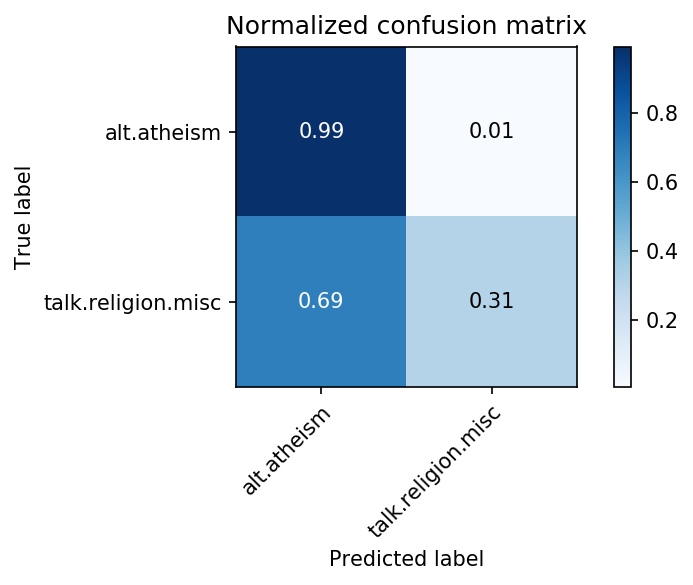

In [18]:
plot_confusion_matrix(y_test, y_predict, 
                      classes=newsgroups_dataset.target_names,
                      title='Normalized confusion matrix')

In [19]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=10, random_state=1)
classifier.fit(bow_X_train, y_train)
y_predict = classifier.predict(bow_X_test)

In [20]:
print(f'Accuracy: {sklearn.metrics.accuracy_score(y_predict, y_test):.2f}')
print(f'F1 score: {sklearn.metrics.f1_score(y_test, y_predict):.2f}')
print(f'Recall: {sklearn.metrics.recall_score(y_test, y_predict):.2f}')
print(f'F1 score: {sklearn.metrics.f1_score(y_test, y_predict):.2f}')

Accuracy: 0.86
F1 score: 0.07
Recall: 0.04
F1 score: 0.07


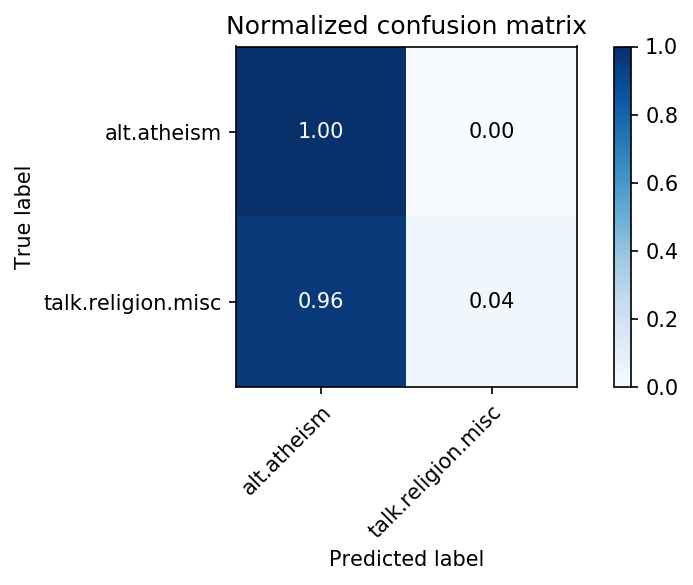

In [21]:
plot_confusion_matrix(y_test, y_predict, 
                      classes=newsgroups_dataset.target_names,
                      title='Normalized confusion matrix')

$F1$ score is great, but sometimes either $P$ or $R$ can be used by itself to choose models.

For moderation at BV we use precision.

# Multiclass confusion matrix

1664 training documents and 821 test documents.


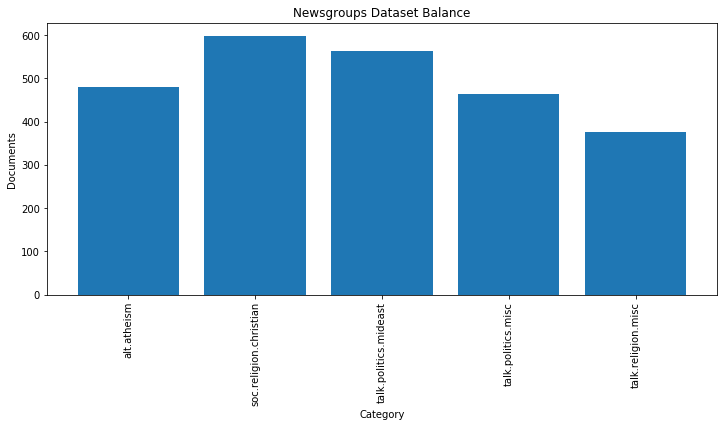

In [22]:
categories = ['talk.religion.misc', 'alt.atheism', 'soc.religion.christian', 
              'talk.politics.mideast', 'talk.politics.misc']
newsgroups_dataset = fetch_20newsgroups(categories=categories)

X_train, X_test, y_train, y_test = train_test_split(newsgroups_dataset.data, 
                                                    newsgroups_dataset.target, 
                                                    test_size=0.33, 
                                                    random_state=1, 
                                                    shuffle=True)
print(f'{len(X_train)} training documents and {len(X_test)} test documents.')

plot_newsgroups_histogram(newsgroups_dataset.target, newsgroups_dataset.target_names)

In [24]:
bow_vectorizer = CountVectorizer(lowercase='true', stop_words='english')
bow_vectorizer.fit(X_train)
bow_X_train = bow_vectorizer.transform(X_train) 
bow_X_test = bow_vectorizer.transform(X_test)

print(f'Vocabulary size: {len(bow_vectorizer.vocabulary_)}')

Vocabulary size: 30772


In [25]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='auto', random_state=1)
classifier.fit(bow_X_train, y_train)
y_predict = classifier.predict(bow_X_test)
print(f'Accuracy: {sklearn.metrics.accuracy_score(y_predict, y_test):.2f}')

Accuracy: 0.93


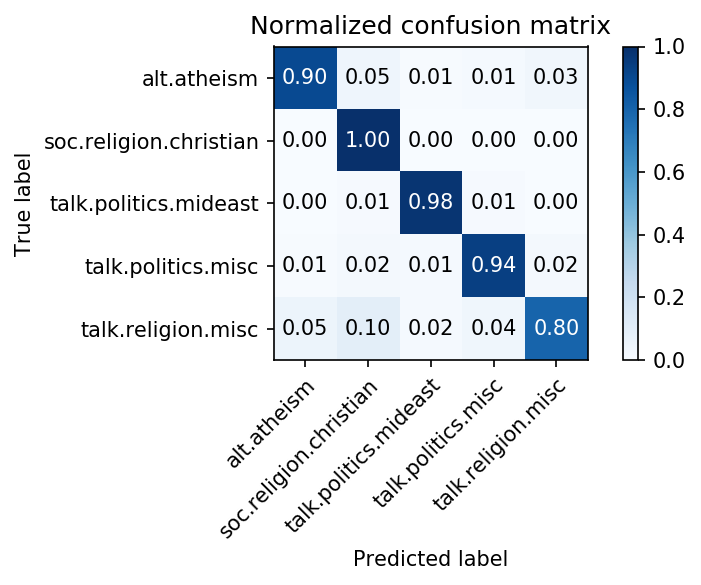

In [26]:
plot_confusion_matrix(y_test, y_predict, 
                      classes=newsgroups_dataset.target_names,
                      title='Normalized confusion matrix')

# Further reading 

##### ROC_AUC curve

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

##### Cross validation

https://machinelearningmastery.com/k-fold-cross-validation/

##### Books
https://www.amazon.co.uk/Introduction-Machine-Learning-Python-Sarah/dp/1449369413/ref=sr_1_1?keywords=introduction+to+machine+learning+with+python&qid=1555014426&s=gateway&sr=8-1

https://www.amazon.co.uk/Deep-Learning-Python-Francois-Chollet/dp/1617294438/ref=sr_1_1?keywords=deep+learning+with+python&qid=1555014456&s=gateway&sr=8-1